In [1]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

In [2]:
import pandas as pd
from random import seed
import random as rm
import numpy as np
import pyemma

from tqdm.notebook import tqdm  # progress bar

In [3]:
import deeptime
deeptime.__version__

'0.4.4'

In [4]:
class TwoCats(object):
    # two cat model with happy and sad states
    # these two cat are coupled
    # the two cat model is a markov chain
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0, 0.1, 0.6, 0, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.9, 0.3, 0.5, 0, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0, 0.1, 0.6, 0.9, 0.3, 0.5])
        elif self._state == "OO":
            return np.asarray([0.9, 0.3, 0.5, 0.9, 0.3, 0.5])
        
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        
        noise[:, 2] += np.random.normal(0, 1, self._trajectory.shape[0])
        noise[:, 5] += np.random.normal(0, 1, self._trajectory.shape[0])
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC", "OC","CO", "OO"]
    
    single_states = ["C", "O"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_OC", "CC_OO"],
                      ["CO_CC", "CO_CO", "CO_OC", "CO_OO"],
                      ["OC_CC", "OC_CO", "OC_OC", "OC_OO"],
                      ["OO_CC", "OO_CO", "OO_OC", "OO_OO"]]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0],
                        [0.3, 0.1, 0.0, 0.6],
                        [0.3, 0.1, 0.0, 0.6],
                        [0.0, 0.1, 0.1, 0.8]]

In [5]:
glic_dimer = TwoCats(0)

In [6]:
glic_dimer.run(50000)

In [7]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1,context='poster')
sns.set_context({"figure.figsize": (12, 12)})

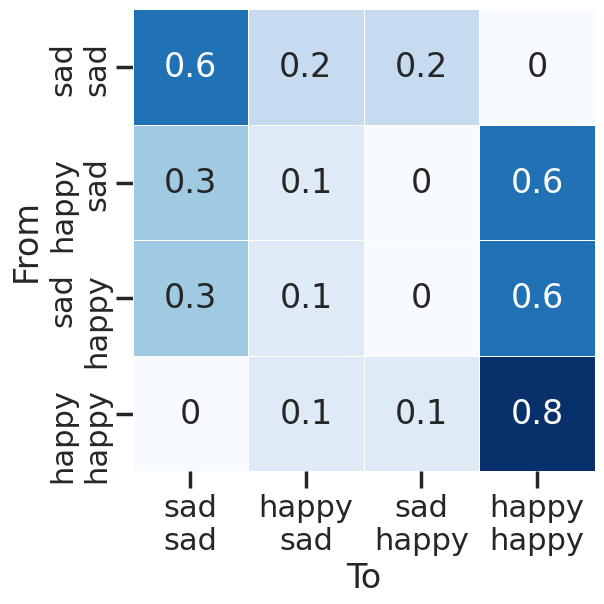

In [89]:
fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(glic_dimer.transitionMatrix,
            ax=ax,
            xticklabels=glic_dimer.states,
            yticklabels=glic_dimer.states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            )

ax.set_xlabel("To")
ax.set_ylabel("From")

# replace CC ticks with sad-sad
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = "sad\nsad"
labels[1] = "happy\nsad"
labels[2] = "sad\nhappy"
labels[3] = "happy\nhappy"

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
fig.savefig('/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/transition_mat.pdf',
            dpi=300,
            bbox_inches='tight',
            transparent=True)

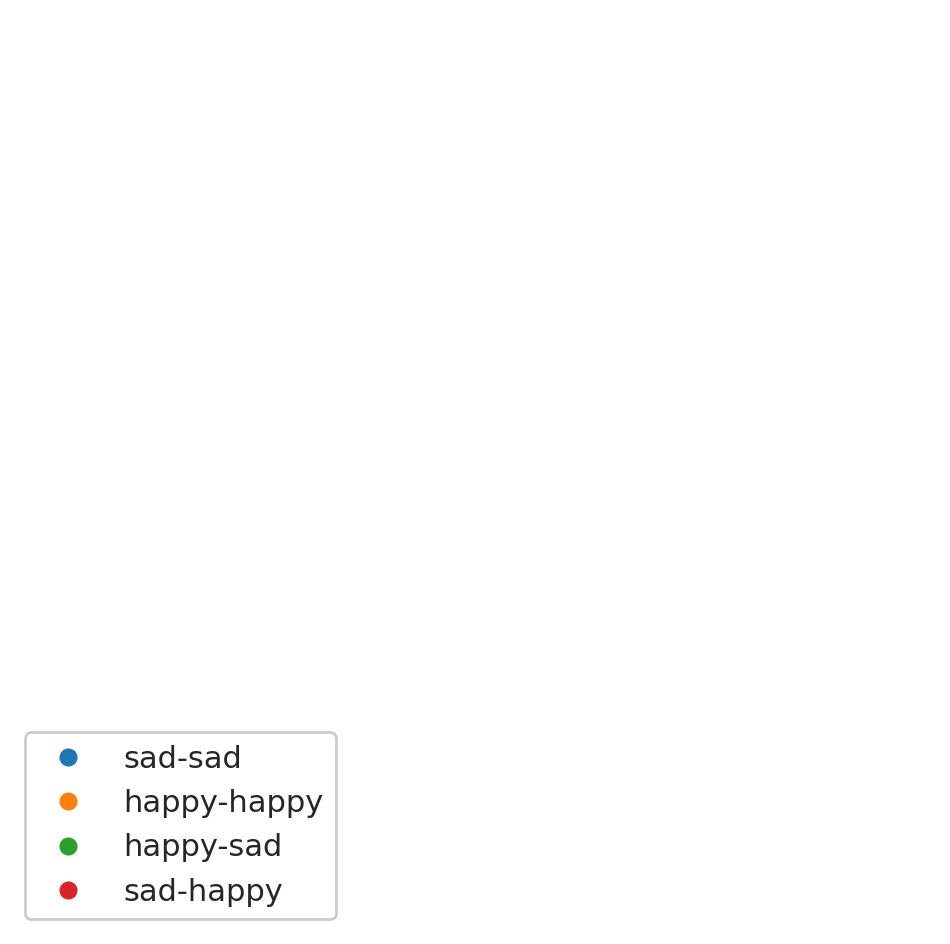

In [39]:
import matplotlib.pyplot as plt

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("o", c) for c in colors]
labels = ["sad-sad", "happy-happy", "happy-sad", "sad-happy"]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=True)

fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
legend.axes.axis("off")
fig.savefig('/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/legend.pdf',
            dpi=300,
            bbox_inches=bbox,
            transparent=True)

In [12]:
from deeptime.markov import pcca

In [13]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [14]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

In [15]:
from pyemma.coordinates import pca

pca_model = pca()

pca_model.fit(np.concatenate(dataset.trajectories))

pca_output= [pca_model.transform(traj) for traj in dataset.trajectories]
pca_concatenated= pca_output[0]

/nethome/yzhuang/anaconda3/envs/msm/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "pca". Called from /nethome/yzhuang/anaconda3/envs/msm/lib/python3.10/site-packages/decorator.py line 232. Use sklearn.decomposition.PCA instead.
  return caller(func, *(extras + args), **kw)


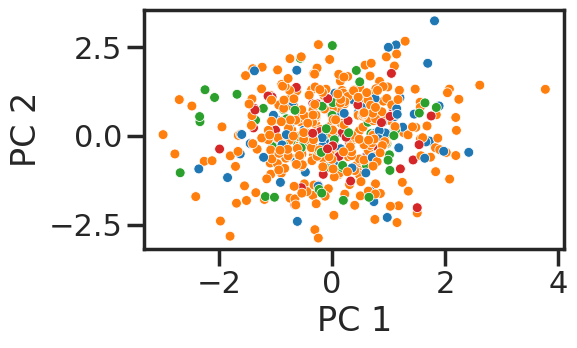

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.scatterplot(
            x=pca_concatenated[::100, 0],
            y=pca_concatenated[::100, 1],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=ax, legend=False, palette=colors)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
# switch legend from CC to sad-sad

plt.tight_layout()
#plt.savefig("assets/tica_dimer.pdf", dpi=300, transparent=True)

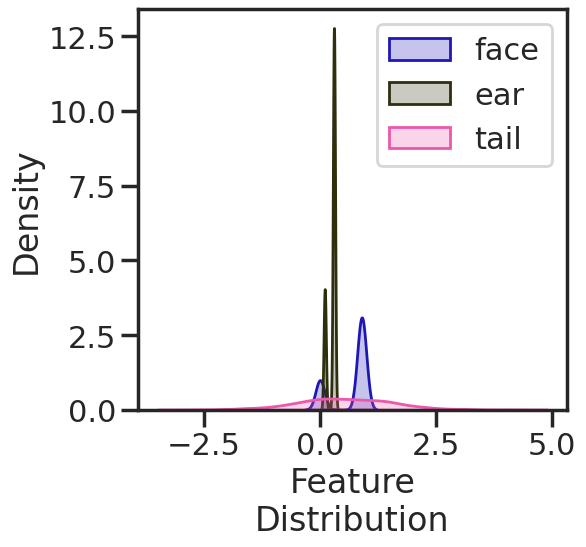

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
colors_feat = ['#1f17b4', '#2f2f0e', '#ec58ac']
for i, (feature_traj, feat) in enumerate(zip(np.concatenate(dataset.trajectories).T, ['face', 'ear', 'tail'])):
    sns.kdeplot(feature_traj[::100], shade=True, ax=ax, label=feat, color=colors_feat[i])
ax.set_xlabel("Feature\nDistribution")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.savefig("/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/cat_features.pdf", dpi=300, transparent=True)

In [31]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= [tica.transform(traj) for traj in dataset.trajectories]
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

/tmp/ipykernel_397664/2677026914.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


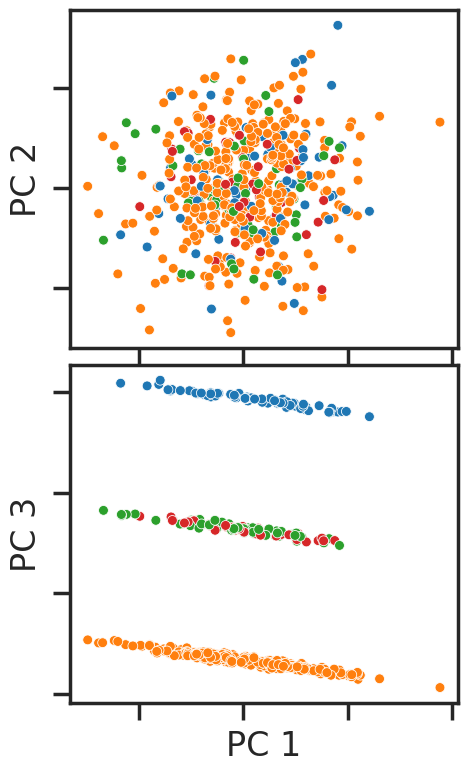

In [37]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(2, 1, figsize=(5,9), sharex=True, gridspec_kw={'hspace': 0.05})
sns.scatterplot(
            x=pca_concatenated[::100, 0],
            y=pca_concatenated[::100, 1],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[0], legend=False,
            palette=colors)

axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
# switch legend from CC to sad-sad

sns.scatterplot(
            x=pca_concatenated[::100, 0],
            y=pca_concatenated[::100, 2],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[1], legend=False,
            palette=colors)

axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 3")
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_yticklabels([])

plt.tight_layout()
plt.savefig("/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/cat_pca.pdf", dpi=300, transparent=True, bbox_inches='tight')

/tmp/ipykernel_397664/2306797965.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


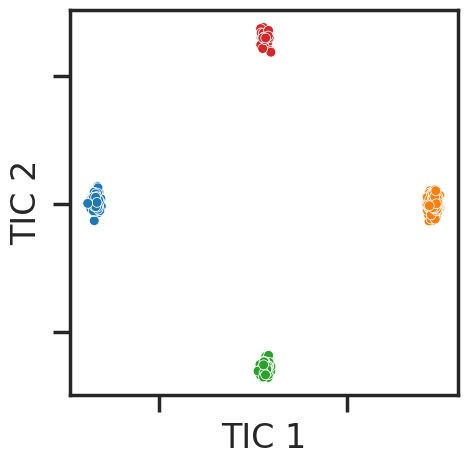

In [38]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, gridspec_kw={'hspace': 0.02})
sns.scatterplot(
            x=feature_transformed[::100, 0],
            y=feature_transformed[::100, 1],
            hue=glic_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=ax, legend=False, palette=colors)

ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_xticklabels([])
ax.set_yticklabels([])
# switch legend from CC to sad-sad

plt.tight_layout()
plt.savefig("/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/cat_tica.pdf", dpi=300, transparent=True, bbox_inches='tight')

In [34]:
from sym_msm.decomposition.sym_tica import SymTICA

symtica = SymTICA(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
symtica_concatenated= np.concatenate(symtica_output)

symmetry_fold 2


In [35]:
symtica_model_tica = symtica.fetch_model()

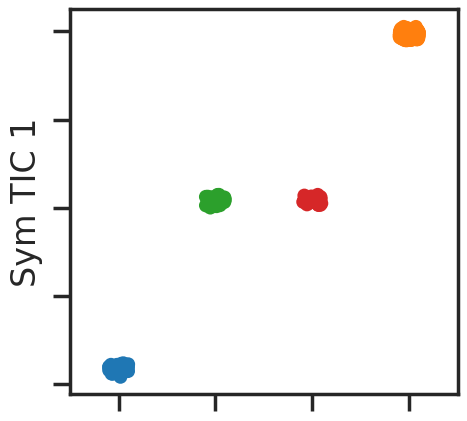

In [43]:
feature = dataset.trajectories[0]
feature_transformed = symtica.transform(feature)
fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(x=glic_dimer.trajectory_states[::100],
              y=feature_transformed[::100, 0],
              hue=glic_dimer.trajectory_states[::100],
              order=glic_dimer.states,
              s=10, alpha=1, ax=ax, palette=colors
              )
ax.set_xlabel("")
ax.set_ylabel("Sym TIC 1")
# hide legend
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend_.remove()
plt.savefig("/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/cat_symtica.pdf", dpi=300, transparent=True, bbox_inches='tight')

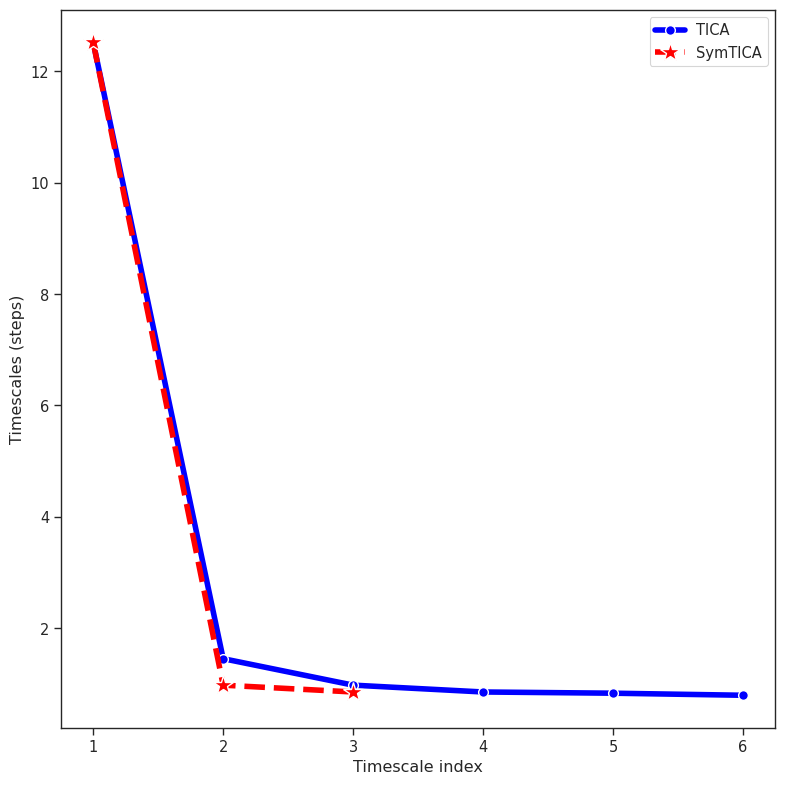

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
n_timescales=100

ax.plot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
        tica_model_tica.timescales(k=n_timescales),
             marker='o',
             linestyle='-',
             linewidth=4,
             color='blue',
             markersize=7,
             markeredgecolor='white',
             label='TICA')
ax.plot(np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1),
             symtica_model_tica.timescales(k=n_timescales),
             marker='*',
             linestyle='--',
             linewidth=4,
             color='red',
             markersize=15,
             markeredgecolor='white',
            label='SymTICA')


ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("assets/dimer_timescales.pdf", dpi=300, transparent=True)

In [45]:
from deeptime.clustering import KMeans, RegularSpace

kmean = KMeans(
                n_clusters=3,
                init_strategy='kmeans++',
                max_iter=300,
                n_jobs=24,
                progress=tqdm)

In [46]:
cluster = kmean.fit(symtica_output).fetch_model()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [47]:
dtrajs = cluster.transform(symtica_output)

In [48]:
cluster_centers = cluster.cluster_centers

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

03-04-23 22:59:27 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[8] WARNING  Changed user setting nits to the number of available timescales nits=2


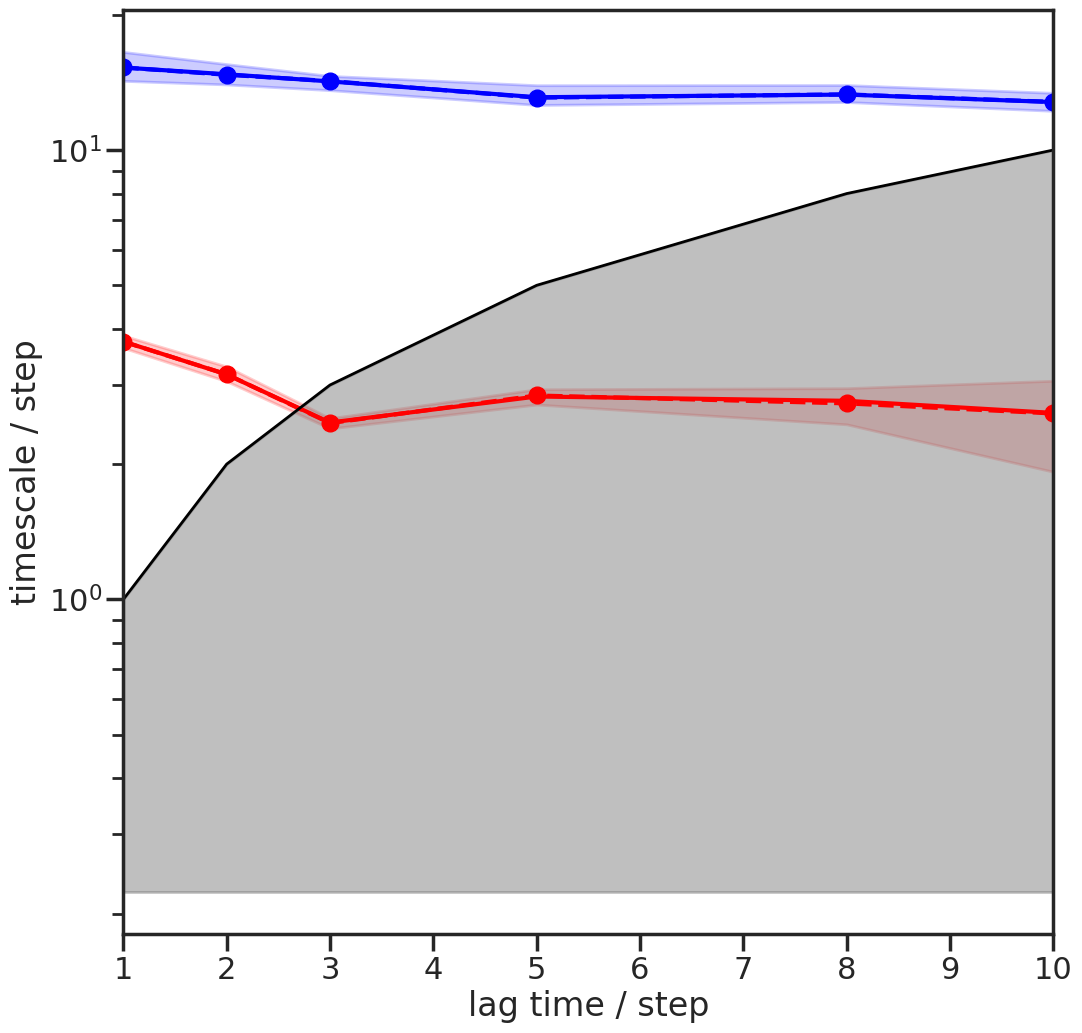

In [49]:
its = pyemma.msm.its(dtrajs, lags=10, nits=10, errors='bayes', n_jobs=1)
pyemma.plots.plot_implied_timescales(its, units='step', dt=1);

In [50]:
from deeptime.markov import TransitionCountEstimator
lag = 5
from deeptime.markov.msm import BayesianMSM, MaximumLikelihoodMSM

counts = TransitionCountEstimator(lagtime=lag,
                                  count_mode='effective').fit_fetch(dtrajs)
msm = BayesianMSM(n_samples=100).fit(counts)

msm_model = msm.fetch_model()

from deeptime.markov.tools.analysis import stationary_distribution

pi_samples = []
traj_weights_samples = []
for sample in msm_model.samples:
    pi_samples.append(stationary_distribution(sample.transition_matrix))
    traj_weights_samples.append(sample.compute_trajectory_weights(dtrajs))

pi_samples = np.array(pi_samples, dtype=object)
traj_weights_samples = np.array(traj_weights_samples, dtype=object)

stationary_distribution = np.mean(pi_samples, axis=0)
pi = stationary_distribution
trajectory_weights = np.mean(traj_weights_samples, axis=0)

In [51]:
n_states = 3

lagtimes = np.arange(1, 7+1) * lag

print('Estimating lagtimes', lagtimes)

models = []
for lagtime in tqdm(lagtimes, desc='lagtime', total=len(lagtimes)):
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs)
    models.append(BayesianMSM(n_samples=100).fit_fetch(counts))

ck_test = models[0].ck_test(models, n_states, progress=tqdm)

Estimating lagtimes [ 5 10 15 20 25 30 35]


lagtime:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

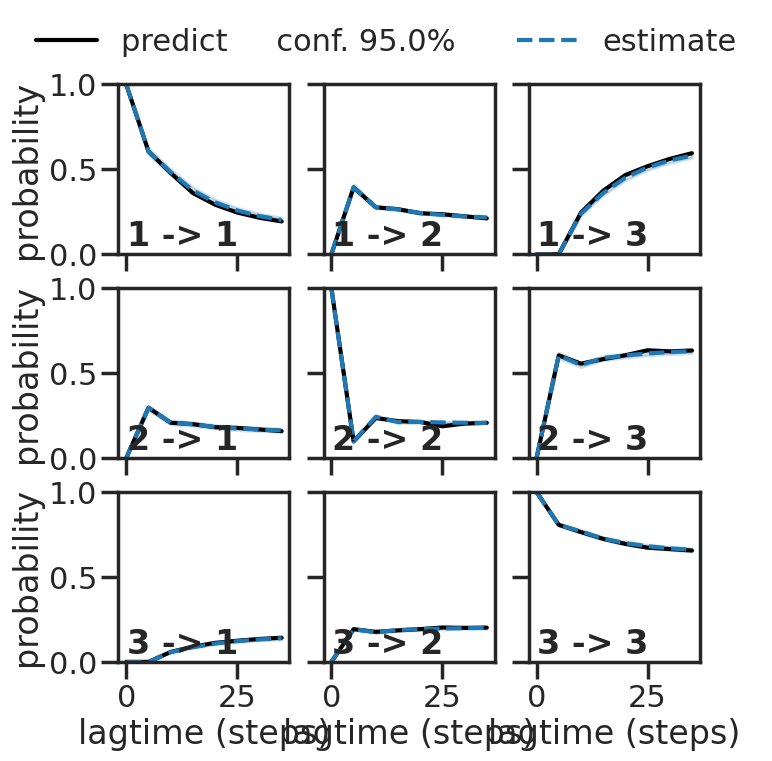

In [52]:
from deeptime.plots import plot_implied_timescales, plot_ck_test

plot_ck_test(ck_test)

<Axes: >

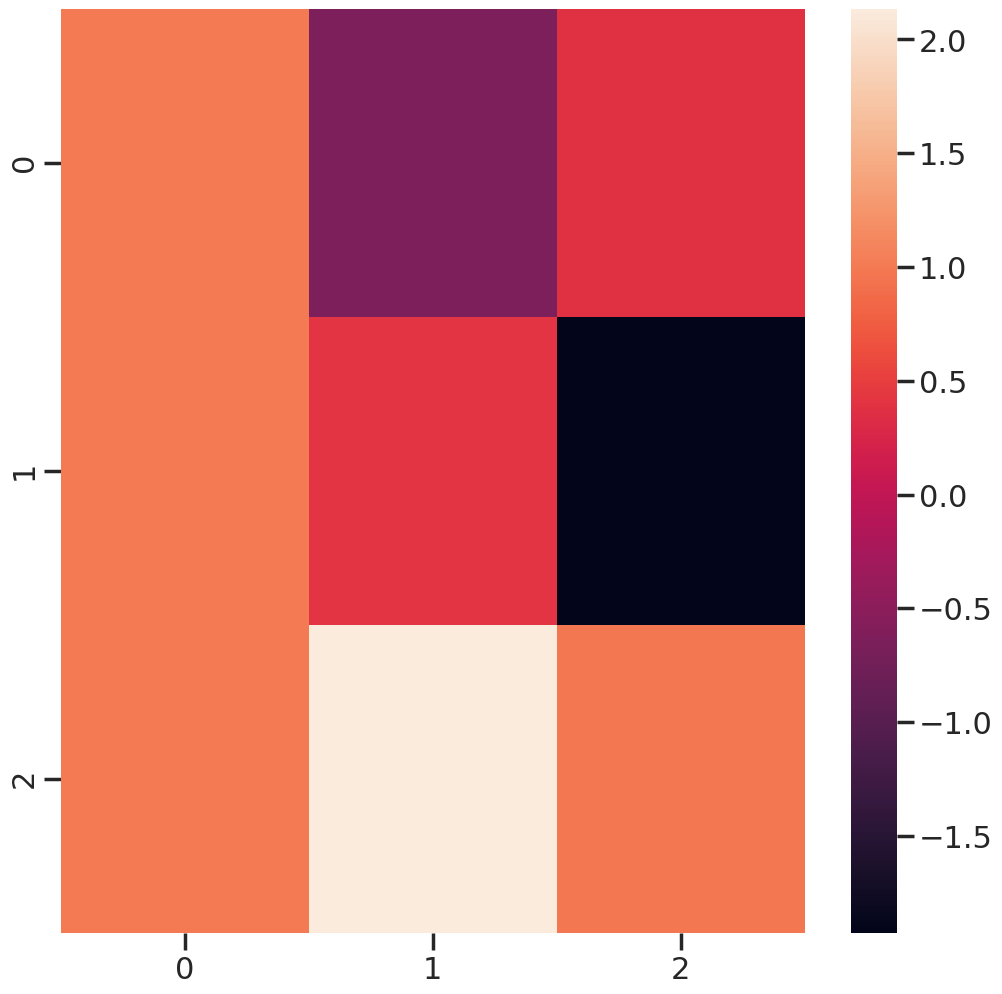

In [53]:
sns.heatmap(msm_model.prior.eigenvectors_right())

<Axes: >

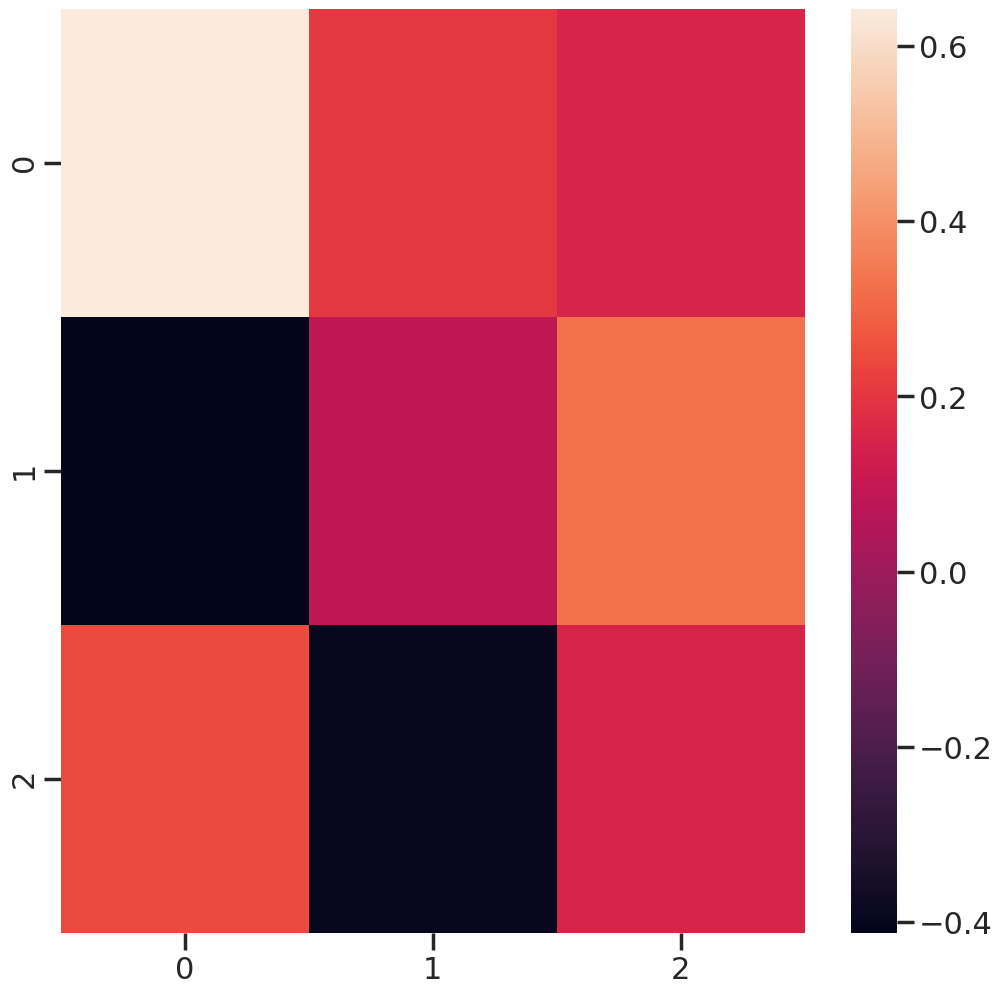

In [54]:
sns.heatmap(msm_model.prior.eigenvectors_left())

IndexError: index 1 is out of bounds for axis 0 with size 1

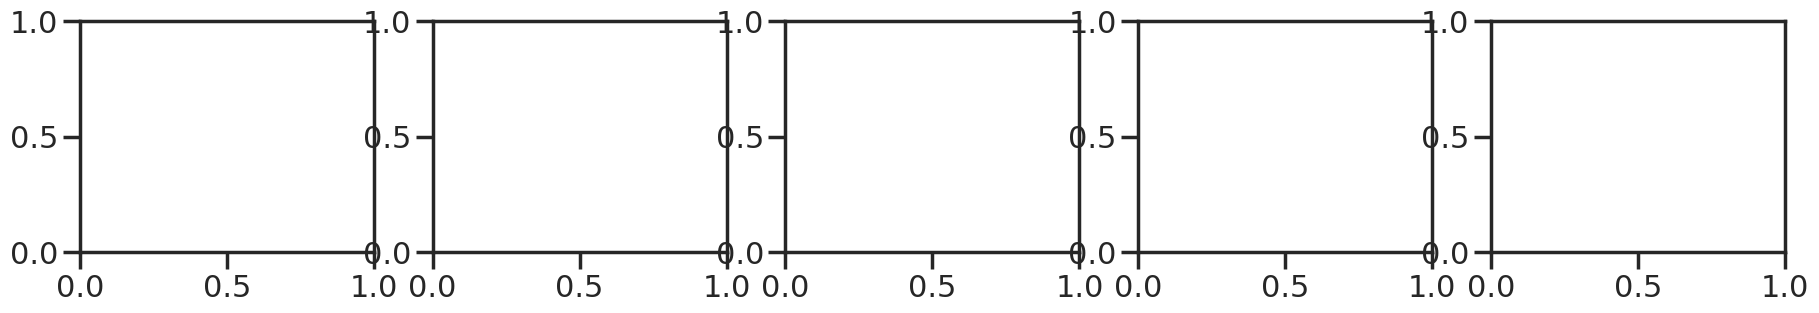

In [80]:
eigvec = msm_model.prior.eigenvectors_right()
fig, axes = plt.subplots(1, 5, figsize=(22, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *symtica_output.T[[0,1]], eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.set_xlabel('$x$')
axes[0].set_ylabel('$y$')
fig.tight_layout()

In [55]:
pcca = msm_model.prior.pcca(n_states)

In [56]:
metastable_traj = [pcca.assignments[c_traj] for c_traj in dtrajs]

In [57]:
print('label\tstate\tπ\t\tG/kT')
p_list = []
for i, s in enumerate(pcca.sets):
    p = stationary_distribution[s].sum()
    print('{}\t{}\t{:f}\t{:f}'.format('d', i + 1, p, -np.log(p)))
    p_list.append(p)

p_list = np.array(p_list)

label	state	π		G/kT
d	1	0.152934	1.877751
d	2	0.204163	1.588837
d	3	0.642903	0.441761


In [84]:
pcca.coarse_grained_transition_matrix

array([[ 6.06099930e-01,  3.93900070e-01, -6.42182889e-18],
       [ 2.96332512e-01,  9.87775060e-02,  6.04889982e-01],
       [ 4.86204144e-17,  1.92733509e-01,  8.07266491e-01]])

In [58]:
highest_membership = pcca.metastable_distributions.argmax(1)
coarse_state_centers = cluster_centers[highest_membership]

In [59]:
from itertools import product

mfpt = np.zeros((n_states, n_states))
mfpt_std = np.zeros((n_states, n_states))

for i, j in product(range(n_states), repeat=2):
    stats_mfpt = msm_model.gather_stats("mfpt",
                                        A=pcca.sets[i],
                                        B=pcca.sets[j])
    mfpt[i, j] = stats_mfpt.mean

    mfpt_std[i, j] = stats_mfpt.std

In [60]:
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [78]:
coarse_state_centers_plot = np.vstack([coarse_state_centers.T, np.array([0, 3, 1])])

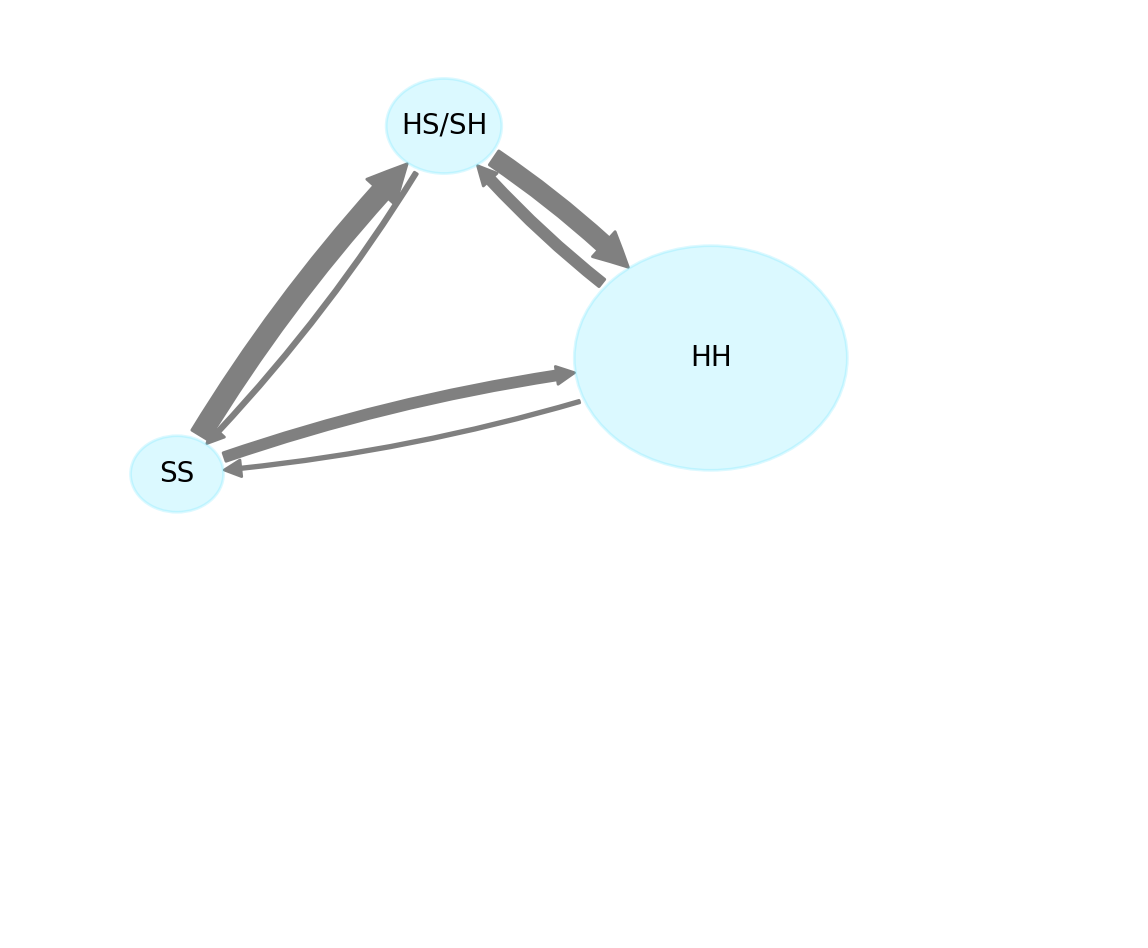

In [86]:
fig, ax = plt.subplots(figsize=(12, 10))
inverse_mfpt_direct = inverse_mfpt.copy()

pyemma.plots.plot_network(
    inverse_mfpt_direct,
    pos=coarse_state_centers_plot.T,
    figpadding=0,
    arrow_label_format='%.4f',
    arrow_labels=None,
    arrow_scale=1,
    state_colors='#3cdfff2f',
    state_scale=5,
    state_sizes=p_list ** 1.5,
    size=20,
    show_frame=False,
    state_labels=['SS', 'HS/SH', 'HH'],
    ax=ax)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
fig.tight_layout()
plt.savefig("/nethome/yzhuang/git_repo/a7_msm_manuscript/src/figures/assets/toy_model/cat_msm.pdf", dpi=300, transparent=True)